# Quenches, ramps e histerese (assinatura de 1ª ordem)

**Objetivo.** Mostrar, de forma quantitativa e visual, a **transição de fase de 1ª ordem coletiva** no sistema:
- Curvas **rampa-acima** (ε↑) e **rampa-abaixo** (ε↓) para $|\langle M\rangle|$, $\langle\sigma\rangle$, $p_\infty^{\rm ramp}$ com **histerese**.
- Histogramas de $x$ perto da faixa crítica, exibindo **coexistência/bimodalidade**, a marca registrada de 1ª ordem.


## Imports & Setup

In [7]:
import os, json, math, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
# garante que o pacote local seja enxergado (repo/notebooks -> adicionar o diretório pai)
sys.path.append(os.path.dirname(os.getcwd()))

from gcm.core import Config, GloballyCoupledMaps
from gcm.metrics import spins, persistence_curve, magnetization, order_param_M
from gcm.maps import sync_boundaries, escape_boundaries, bistable_intervals


def run_with_ic(mu, eps, N=512, init="half_half", T_burn=600, T_meas=600, seed=0):
    """Roda com um init padrão do core; retorna (traj, sys)."""
    cfg = Config(N=N, eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.reset(init=init)
    sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)
    return traj, sys

def run_track_including_initial(cfg, init_kind="half_half", x0=None, T=400, seed=None):
    """
    Executa e retorna uma matriz (T+1, N) que INCLUI o estado inicial na linha 0.
    Se x0 for fornecido, usa-o diretamente; caso contrário, chama reset(init_kind).
    """
    from gcm.core import GloballyCoupledMaps
    sys = GloballyCoupledMaps(cfg)
    if x0 is None:
        sys.reset(init=init_kind)
    else:
        sys.x = np.array(x0, dtype=float)
    N = sys.x.size
    hist = np.empty((T+1, N), dtype=float)
    hist[0] = sys.x.copy()
    for t in range(T):
        sys.step()
        hist[t+1] = sys.x.copy()
    return hist, sys

def lambdas(mu, eps, x_series_for_lambda):
    """Retorna (λ_teo, λ_est, λ_perp) para exibir/checar."""
    lam_teo = math.log(abs(mu))                         # λ = ln|μ|
    lam_est = estimate_lambda_local(x_series_for_lambda, mu)
    lam_perp = math.log(abs(1.0 - eps)) + lam_teo      # λ⊥ = ln|1-ε| + λ
    return lam_teo, lam_est, lam_perp


FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(parents=True, exist_ok=True); DATA.mkdir(parents=True, exist_ok=True)

# Paleta de regiões (igual ao 00/01/02)
COL_NON_SYNC  = "#e09f3e"   # não sincronizado (Honey Bronze)
COL_SYNC_STAT = "#335c67"   # síncrono estacionário (Dark Slate Grey)
COL_SYNC_CHAOS= "#9fd356"   # síncrono caótico (Yellow Green)
COL_ESCAPE    = "#9e2a2b"   # escape (Brown Red)

# Cores das curvas dos observáveis
COL_CURVE_M     = "#7e57c2"  # roxo (|<M>|)
COL_CURVE_SIGMA = "#e09f3e"  # laranja (<σ>)
COL_CURVE_P     = "#2e7d32"  # verde (p∞^ramp)

MU = 1.9
N  = 4096  # pode subir se quiser


In [8]:

def reconfigure_system(sys, new_eps):
    """Cria um novo sistema com mesmo μ e N, copiando o estado x, mas mudando ε."""
    cfg2 = Config(N=sys.cfg.N, eps=float(new_eps), mu=sys.cfg.mu, seed=sys.cfg.seed)
    sys2 = GloballyCoupledMaps(cfg2)
    sys2.x = sys.x.copy()
    return sys2

def step_and_measure(sys, T_burn, T_meas):
    """Avança T_burn+T_meas passos e retorna (traj_medicao, sigma_bar, M_bar, p_infty_window)."""
    if T_burn>0:
        sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)   # (T_meas, N)

    sigmas = np.std(traj, axis=1)
    sigma_bar = float(np.mean(sigmas))

    Ms = np.apply_along_axis(lambda x: magnetization(x), 1, traj)
    M_bar = float(order_param_M(Ms))

    S = spins(traj)
    p_t = persistence_curve(S)
    p_inf_window = float(p_t[-1])   # persistência no "bloco" da janela

    return traj, sigma_bar, M_bar, p_inf_window

def make_eps_schedule(eps_min, eps_max, nsteps, mode="updown"):
    base = np.linspace(eps_min, eps_max, nsteps)
    if mode == "up":
        return base
    if mode == "down":
        return base[::-1]
    if mode == "updown":
        return np.concatenate([base, base[-2::-1]])
    raise ValueError("mode ∈ {'up','down','updown'}")

def shade_sync_band(ax, mu, color, alpha=0.15):
    a, b = sync_boundaries(mu)
    left = max(0, a); right = min(2.2, b)
    if left < right:
        ax.axvspan(left, right, color=color, alpha=alpha, linewidth=0)
        ax.axvline(a, color=color, lw=1.2, ls="--")
        ax.axvline(b, color=color, lw=1.2, ls="--")


## Parte A — Ramps em ε (ε↑ e ε↓) e histerese

**Ideia.** Vamos manter $\mu=1.9$, assim como feito no artigo e varreremos $\varepsilon$:
1. **ε↑**: de $ε_{min}$ → $ε_{max}$ em passos finos; em cada patamar, rodamos `T_burn` para acomodar e `T_meas` para medir.
2. **ε↓**: retornamos $ε_{max}$ → $ε_{min}$, retomando do **último estado** (mesmo `x`), repetindo queimas e medidas.

**Assinatura de 1ª ordem.**
- **Histerese**: curvas *ε↑* e *ε↓* **não coincidem**, mostrando **metástabilidade** e **coexistência de fases**.
- **Salto** em $|\langle M\rangle|$: mudança **abrupta** em ε $ε_c$ — típico de transição **descontínua**.
- **Bimodalidade** em histogramas de $x$ perto da comutação (Parte B).

In [14]:
# Parâmetros do protocolo (ajuste "modo publicação" vs "rápido")
EPS_MIN, EPS_MAX, NSTEPS = 0.20, 1.60, 24   # cobre fora e dentro da banda (~0.473–1.526)
T_BURN_BLOCK  = 800
T_MEAS_BLOCK  = 800
SEED0 = 31415

# IC "half_half" padrão (bacias I±)
cfg0 = Config(N=N, eps=EPS_MIN, mu=MU, seed=SEED0)
sys0 = GloballyCoupledMaps(cfg0); sys0.reset(init="half_half")

eps_up   = np.linspace(EPS_MIN, EPS_MAX, NSTEPS)
eps_down = eps_up[::-1]

def run_branch(sys_start, eps_schedule):
    sys = sys_start
    rows = []

    # Spins de referência no INÍCIO da rampa
    s0 = spins(sys.x[None, :])[0]      # shape (N,)
    changed = np.zeros(sys.cfg.N, dtype=bool)

    for k, eps in enumerate(eps_schedule):
        # reconfigura ε mantendo o mesmo estado x
        if k == 0:
            if abs(sys.cfg.eps - eps) > 1e-12:
                sys = reconfigure_system(sys, eps)
        else:
            sys = reconfigure_system(sys, eps)

        # ---- burn-in (conta para persistência) ----
        if T_BURN_BLOCK > 0:
            traj_burn = sys.run(T_BURN_BLOCK, track=True)        # (T_burn, N)
            Sb = spins(traj_burn)                                # (T_burn, N)
            changed |= np.any(Sb != s0, axis=0)

        # ---- janela de medição (conta para persistência + métricas) ----
        traj = sys.run(T_MEAS_BLOCK, track=True)                 # (T_meas, N)
        Sm = spins(traj)                                         # (T_meas, N)
        changed |= np.any(Sm != s0, axis=0)

        # métricas na janela de medição
        sigmas = np.std(traj, axis=1)
        sigma_bar = float(np.mean(sigmas))
        Ms = np.apply_along_axis(lambda x: magnetization(x), 1, traj)
        M_bar = float(order_param_M(Ms))

        # persistência ACUMULADA desde o início da rampa
        p_global = float(1.0 - np.mean(changed))

        rows.append({
            "eps": float(eps),
            "sigma_bar": sigma_bar,
            "M_bar": M_bar,
            "p_inf_global": p_global,       # <--- usamos este no plot
            "x_final_mean_abs": float(np.mean(np.abs(sys.x))),
            "escaped_frac": float(np.mean(np.abs(sys.x) > 1.0))
        })
    return rows, sys

# Branch ε↑
rows_up, sys_top = run_branch(sys0, eps_up)
# Branch ε↓ (continua do topo — metástabilidade preservada)
rows_dn, sys_end = run_branch(sys_top, eps_down)

# Empacota e salva
res = {"mu": MU, "N": N,
       "eps_up": eps_up.tolist(), "up": rows_up,
       "eps_down": eps_down.tolist(), "down": rows_dn,
       "params": {"T_BURN_BLOCK": T_BURN_BLOCK, "T_MEAS_BLOCK": T_MEAS_BLOCK}}
(DATA/"week3_ramp_mu1.9.json").write_text(json.dumps(res, indent=2), encoding="utf-8")


11148

ε_c^up  (|<M>|≈0.5) ~ 0.5043
ε_c^down(|<M>|≈0.5) ~ 0.2000
Largura de histerese ~ 0.3043


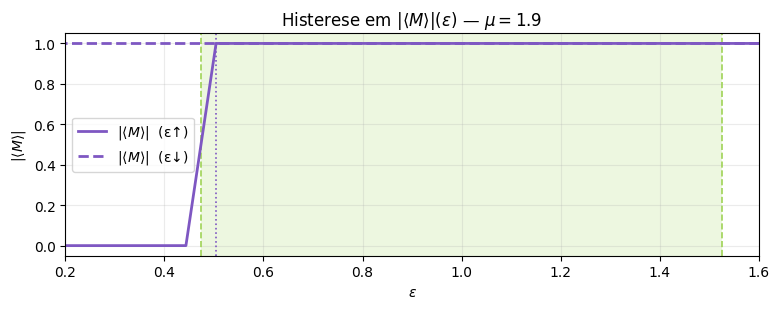

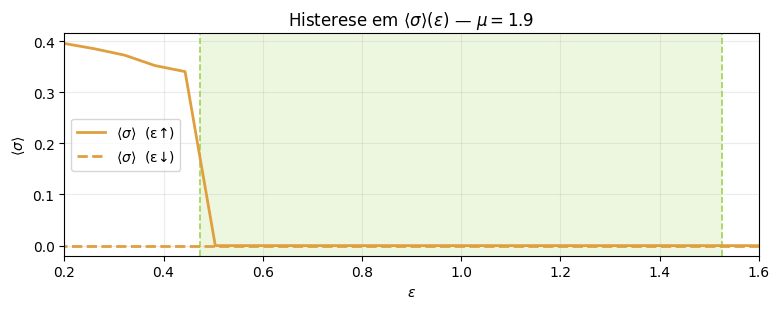

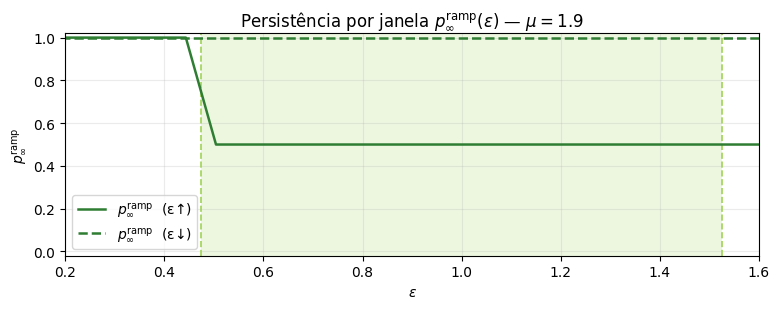

In [15]:
def arrays_from_rows(rows):
    eps = np.array([r["eps"] for r in rows])
    sbar = np.array([r["sigma_bar"] for r in rows])
    Mbar = np.array([r["M_bar"] for r in rows])
    pinf = np.array([r["p_inf_global"] for r in rows])
    xabs = np.array([r["x_final_mean_abs"] for r in rows])
    escf = np.array([r["escaped_frac"] for r in rows])
    return eps, sbar, Mbar, pinf, xabs, escf

epsU, sU, MbarU, pU, xU, eU = arrays_from_rows(rows_up)
epsD, sD, MbarD, pD, xD, eD = arrays_from_rows(rows_dn)

# estimativas simples de ε_c por threshold em |<M>| (pode refinar depois)
def estimate_eps_crit(eps, Mbar, target=0.5):
    # primeira passagem do lado baixo p/ cima
    idx = np.where(Mbar>=target)[0]
    return float(eps[idx[0]]) if idx.size>0 else np.nan

ec_up   = estimate_eps_crit(epsU, MbarU, target=0.5)   # em subida
ec_down = estimate_eps_crit(epsD[::-1], MbarD[::-1], target=0.5)  # em descida (para ler “da esquerda p/ direita”)

print(f"ε_c^up  (|<M>|≈0.5) ~ {ec_up:.4f}")
print(f"ε_c^down(|<M>|≈0.5) ~ {ec_down:.4f}")
print(f"Largura de histerese ~ {abs(ec_up - ec_down):.4f}")

# Fronteiras teóricas (somente referência: sincronização transversal)
eps_sync_inf, eps_sync_sup = sync_boundaries(MU)

# 1) |<M>|(ε)
fig, ax = plt.subplots(figsize=(7.9,3.2))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, alpha=0.18)
ax.plot(epsU, MbarU, lw=2.0, color=COL_CURVE_M, label=r"$|\langle M\rangle|$  (ε↑)")
ax.plot(epsD, MbarD, lw=2.0, color=COL_CURVE_M, ls="--", label=r"$|\langle M\rangle|$  (ε↓)")
ax.axvline(ec_up,   color=COL_CURVE_M, ls=":", lw=1.2)
ax.axvline(ec_down, color=COL_CURVE_M, ls=":", lw=1.2)
ax.set_xlim(EPS_MIN, EPS_MAX)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$|\langle M\rangle|$")
ax.set_title(r"Histerese em $|\langle M\rangle|(\varepsilon)$ — $\mu=1.9$")
ax.grid(alpha=0.25); ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"03_hysteresis_Mbar.png", dpi=220); plt.show()

# 2) <σ>(ε)
fig, ax = plt.subplots(figsize=(7.9,3.2))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, alpha=0.18)
ax.plot(epsU, sU, lw=2.0, color=COL_CURVE_SIGMA, label=r"$\langle\sigma\rangle$  (ε↑)")
ax.plot(epsD, sD, lw=2.0, color=COL_CURVE_SIGMA, ls="--", label=r"$\langle\sigma\rangle$  (ε↓)")
ax.set_xlim(EPS_MIN, EPS_MAX)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$\langle\sigma\rangle$")
ax.set_title(r"Histerese em $\langle\sigma\rangle(\varepsilon)$ — $\mu=1.9$")
ax.grid(alpha=0.25); ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"03_hysteresis_sigma.png", dpi=220); plt.show()

# 3) p_inf^ramp(ε) (janela) — útil para distinguir regimes “ordenado sinc. II” vs turbulento
fig, ax = plt.subplots(figsize=(7.9,3.2))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, alpha=0.18)
ax.plot(epsU, pU, lw=1.8, color=COL_CURVE_P, label=r"$p_\infty^{\rm ramp}$  (ε↑)")
ax.plot(epsD, pD, lw=1.8, color=COL_CURVE_P, ls="--", label=r"$p_\infty^{\rm ramp}$  (ε↓)")
ax.set_xlim(EPS_MIN, EPS_MAX); ax.set_ylim(-0.02, 1.02)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$p_\infty^{\rm ramp}$")
ax.set_title(r"Persistência por janela $p_\infty^{\rm ramp}(\varepsilon)$ — $\mu=1.9$")
ax.grid(alpha=0.25); ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"03_hysteresis_pinf.png", dpi=220); plt.show()


### Leitura física (ligando com o o que vimos antes - 00–02)

* **Onde exatamente está a transição e fase de 1ª ordem?**

- A **banda de sincronização** (linhas verdes tracejadas do 00) controla a **estabilidade transversal**; ela **não** fixa sozinha a ordem de fase.
- A **transição de 1ª ordem coletiva** aparece como:
  1) **Histerese** clara entre **ε↑** e **ε↓** nas curvas de $|\langle M\rangle|$ e $\langle\sigma\rangle$;
O que observamos é o fato de que subirmos $\varepsilon$ ou descermos $\varepsilon$ as curvas se ajustam em momentos diferentes, isso é a característica essencial da transição de fase de primeira ordem.
Essa assinatura aparece por exemplo na transição da água, muitos já ouviram falar do ponto anômolo da água entre -4-0ºC, ou até mesmo de congelarmos a cerveja ao sacurdimos a garrafa.
Isso nada mais é do que uma transição de fase de primeira ordem. Resfriando a água ela permanece liquida mesmo já existindo outro mínimo estável (estado congelado). Ao mesmo tempo ao descongelarmos a água ela permanece congelada, mesmo existindo outro mínimo mais estável (estado líquido), de modo que sua transição de fase não possui uma temperatura bem definida. O congelamento ocorre pois fornecemos energia suficiente para as moléculas atravessarem a barreira de potencial e cair no mínimo mais estável - o estado congelado, na cerveja.
  2) **Salto** abrupto de $|\langle M\rangle|$ em ε (discontinuidade) indicam essa transiça~o;
  3) **Bimodalidade** dos histogramas de $x$ perto da comutação (coexistência de bacias $I_\pm$) - Veremos isso a seguir.

**Marcadores práticos neste notebook**
- Estimativas de $\varepsilon_{\rm c}^{\uparrow}$ e $\varepsilon_{\rm c}^{\downarrow}$ (linhas verticais roxas pontilhadas) definem a **largura de histerese**.
- Nos painéis da Parte B, a **coexistência** fica visível (dois picos claros em $x$); ao cruzar $\varepsilon_{\rm c}$, o sistema “colapsa” de um pico para o outro.


## Parte B - Histogramas perto da comutação (coexistência de fases)

ε selecionados para histogramas: [0.2        0.26086957 0.44347826 0.50434783]


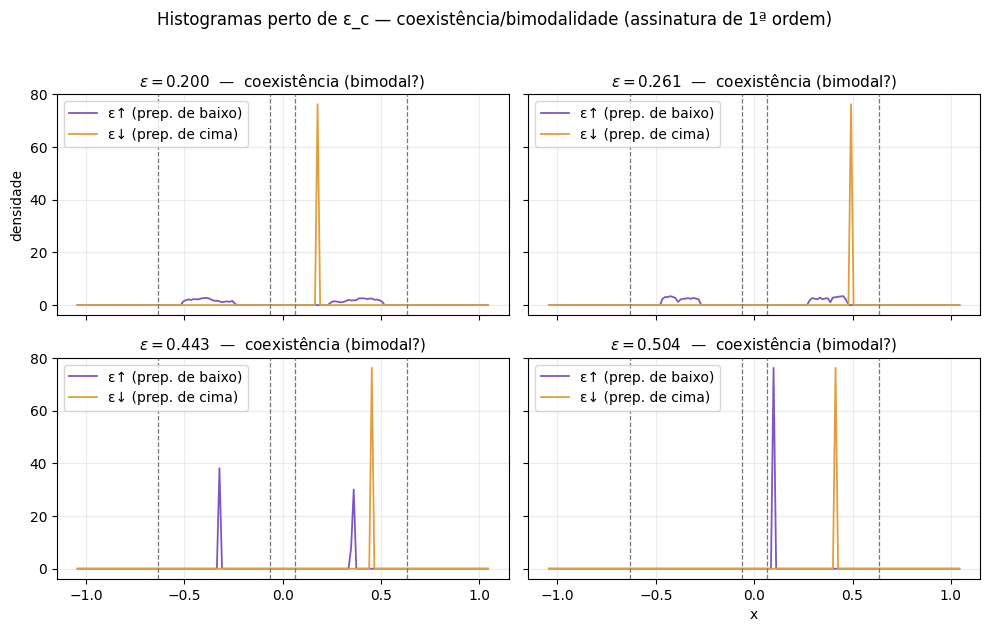

30967

In [16]:
# Escolhe 4 ε próximos de ec_up e ec_down para ilustrar coexistência
def pick_near(values, center, k=2):
    arr = np.array(values)
    idx = np.argsort(np.abs(arr - center))[:k]
    return np.sort(arr[idx])

eps_show = np.unique(np.concatenate([
    pick_near(epsU, ec_up, k=2),
    pick_near(epsD, ec_down, k=2)
]))

print("ε selecionados para histogramas:", eps_show)

# Para cada ε desses, roda uma janela longa a partir do estado 'metastável' adequado
# Estratégia: "preparar" subindo até mais próximo (para ε acima) e descendo até mais próximo (para ε abaixo)
def prepare_state_to_eps(eps_target, mode="up", seed=999):
    # começa em uma extremidade, faz ramp rápida até o alvo (mantendo estado)
    eps_path = np.linspace(EPS_MIN if mode=="up" else EPS_MAX, eps_target, 8)
    sys = GloballyCoupledMaps(Config(N=N, eps=eps_path[0], mu=MU, seed=seed))
    sys.reset(init="half_half")
    for e in eps_path[1:]:
        sys = reconfigure_system(sys, e)
        sys.run(400, track=False)
    return sys

hist_data = {}
BINS = 160
for e in eps_show:
    # prepara por dois lados para evidenciar bacias distintas (se houver)
    sysU = prepare_state_to_eps(e, mode="up",   seed=20231)   # vindo de baixo (ε↑)
    sysD = prepare_state_to_eps(e, mode="down", seed=20232)  # vindo de cima (ε↓)

    # mede em cada preparo
    def sample_hist(sys):
        sys.run(1200, track=False)
        xs = sys.x.copy()
        hist, edges = np.histogram(xs, bins=BINS, range=(-1.05, 1.05), density=True)
        centers = 0.5*(edges[:-1] + edges[1:])
        return centers, hist

    cU, hU = sample_hist(sysU)
    cD, hD = sample_hist(sysD)
    hist_data[float(e)] = {"centers": cU.tolist(), "hist_up": hU.tolist(), "hist_down": hD.tolist()}

# Plota 2x2 (até 4 valores)
m = min(4, len(eps_show))
rows = int(np.ceil(m/2)); cols = 2 if m>1 else 1
fig, axes = plt.subplots(rows, cols, figsize=(10, 3.2*rows), sharex=True, sharey=True)
axes = np.atleast_1d(axes).ravel()

for ax, e in zip(axes, eps_show[:m]):
    d = hist_data[float(e)]
    ax.plot(d["centers"], d["hist_up"],   lw=1.3, color=COL_CURVE_M,     label="ε↑ (prep. de baixo)")
    ax.plot(d["centers"], d["hist_down"], lw=1.3, color=COL_CURVE_SIGMA, label="ε↓ (prep. de cima)")
    # marca I±
    i_minus, i_plus = bistable_intervals(MU)
    for xv in [i_minus[0], i_minus[1], i_plus[0], i_plus[1]]:
        ax.axvline(xv, color="#777777", lw=0.9, ls="--")
    ax.set_title(rf"$\varepsilon={e:.3f}$  —  coexistência (bimodal?)", fontsize=11)
    ax.grid(alpha=0.25); ax.legend(loc="best")

axes[-1].set_xlabel("x"); axes[0].set_ylabel("densidade")
fig.suptitle("Histogramas perto de ε_c — coexistência/bimodalidade (assinatura de 1ª ordem)", y=0.98)
fig.tight_layout(rect=[0,0,1,0.96]); fig.savefig(FIGS/"03_hist_coexistencia.png", dpi=220); plt.show()

# Salva em JSON
(DATA/"03_hist_coexistencia.json").write_text(json.dumps(hist_data, indent=2), encoding="utf-8")


**Interpretação do gráfico:**
- O que obsevamos acima essencialmente é o seguinte fato: dependendo da forma que você varia $\varepsilon$ (equivalente a temperatura na analogia da água) chegamos no mesmo $\varepsilon$ a configurações diferentes do mesmo sistema físico. Ou seja, mantendo o mesmo mapa local e alterando a influência da sua globalidade observamos a quebra de simetria. É claro que isso também está associado ao fato de termos bimalidade - dois estados possíveis acessíveis do sistema.
- **Histerese marcante** em $|\langle M\rangle|$ e $\langle\sigma\rangle$: as curvas de ε↑ e ε↓ **não coincidem**.
- **Saltos** em $|\langle M\rangle|$ localizam $\varepsilon_{\rm c}^{\uparrow,\downarrow}$; a diferença define a **largura de histerese**.
- **Coexistência de bacias** (bimodalidade) perto de ε\_c, confirmando o **caráter de 1ª ordem**.
- A banda de **sincronização transversal** (do 00) explica **onde** a variedade sincronizada é estável; já a **ordem de fase** (audiência $I_+$ vs $I_-$) mostra **saltos** e **metástase** (1ª ordem) sob variação de ε.
